In [0]:
# Pytorch imports
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import (DataLoader,
                              Dataset,
                              TensorDataset)

from torch.optim import Adam, RMSprop, SGD
from torchvision import transforms

# Albumentations imports
from albumentations.pytorch import ToTensor
import albumentations as A

# Sklearn metrics imports 
from sklearn.metrics import (f1_score, 
                             recall_score,
                             balanced_accuracy_score,
                             precision_score, 
                             roc_auc_score, 
                             classification_report, 
                             confusion_matrix)

# For showing the confusion matrix
from mlxtend.plotting import plot_confusion_matrix

# Other imports
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os.path import join
from collections import Counter
import pandas as pd
import seaborn as sns
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
BASE_DIR = '.../chest-xray-pneumonia/chest_xray'
TRAIN_PATH = join(BASE_DIR, 'train')
VAL_PATH = join(BASE_DIR, 'val')
TEST_PATH = join(BASE_DIR, 'test')
FILETYPE = ['NORMAL', 'PNEUMONIA']

def get_data(dir_path=None):
    class_1, class_0, target = [], [], []
    for filetype in FILETYPE:
        for filename in (filename for filename in os.listdir(join(dir_path, filetype)) if '.jpeg' in filename):
            image = cv2.imread(join(dir_path, filetype, filename))
            image = np.dstack([image]*3) if image.ndim==2 else image
            resized = cv2.resize(image, (224, 224))
            if filetype=="NORMAL":
                class_0.append(resized)
                target.append([1, 0])
            else:
                class_1.append(resized)
                target.append([0, 1])
                 
    return np.vstack([class_0, class_1]), np.array(target)

In [0]:
# Load the training, validation and test sets.
X_train, y_train = get_data(TRAIN_PATH)
X_val, y_val = get_data(VAL_PATH)
X_test, y_test = get_data(TEST_PATH)

In [0]:
def visualize_samples(images, rows=1, cols=5, title=None):
    plt.figure(figsize=(2.5*cols, 2.5*rows)).suptitle(title, size=15, color='black')
    idx = np.random.choice(images.shape[0], size=rows*cols)
    for i, sample in enumerate(images[idx]):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(sample)
    plt.show()

visualize_samples(X_train[y_train==0], rows=2, cols=6, title='NORMAL')
visualize_samples(X_train[y_train==1], rows=2, cols=6, title='PNEUMONIA')

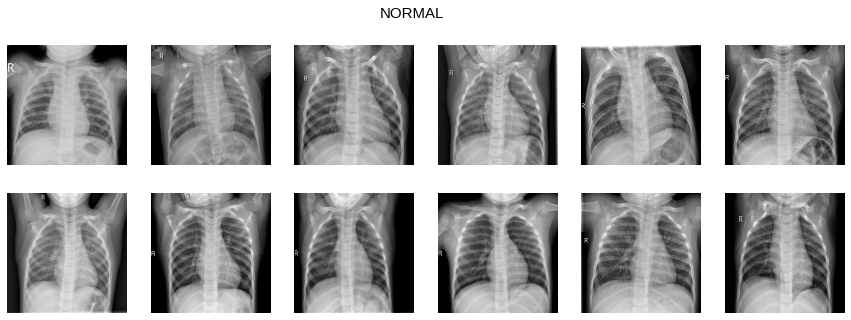

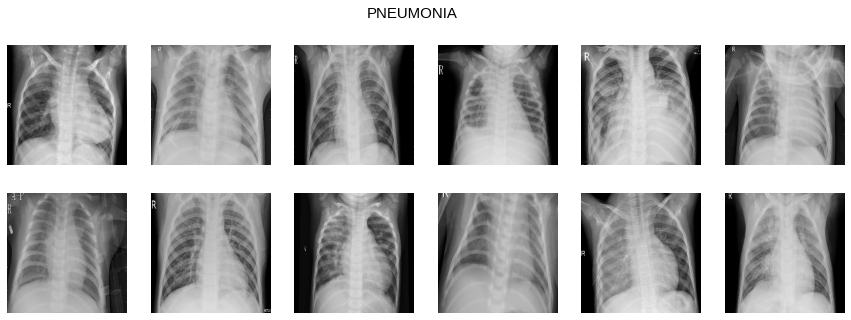

In [0]:
visualize_samples(X_train[y_train==0], rows=2, cols=6, title='NORMAL')
visualize_samples(X_train[y_train==1], rows=2, cols=6, title='PNEUMONIA')

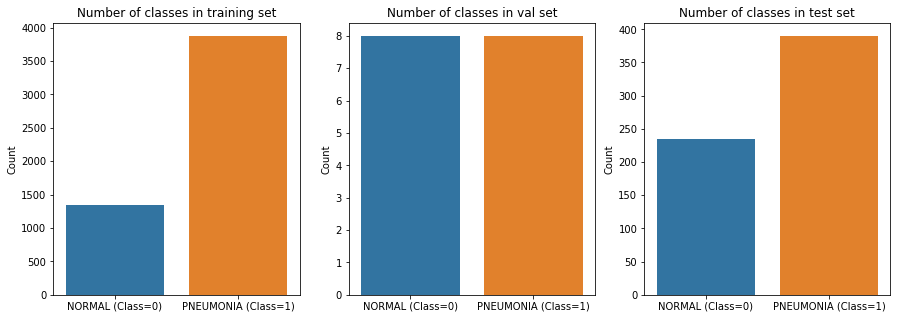

In [4]:
plt.figure(figsize=(15, 5))
for i, (labels, set_name) in enumerate(zip([y_train, y_val, y_test], ['training', 'val', 'test'])):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=['NORMAL (Class=0)', 'PNEUMONIA (Class=1)'], 
                y=list(Counter(labels).values()))
    plt.ylabel("Count")
    plt.title("Number of classes in {} set".format(set_name))
plt.show()

In [0]:
# Defining an augmentation pipeline with Albumentations
aug_pipeline = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=.5),
        A.GaussNoise(),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.2, 
                       rotate_limit=45, p=0.2),
    A.OneOf([
        A.VerticalFlip(p=.5),
        A.OpticalDistortion(p=0.6),
        A.GridDistortion(p=.3),
        A.IAAPiecewiseAffine(p=0.4),
    ], p=0.6),
    ToTensor(),
], p=.5)

In [0]:
# Declaring custom Pytorch Dataset subclasses

class TrainDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform 
  
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = torch.tensor(self.labels[index], dtype=torch.long)
        image = self.transform(image=self.images[index])['image']
        return image, target
        

class ValDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
  
    def __getitem__(self, index):
        image = self.transform(self.images[index])
        target = torch.tensor(self.labels[index], dtype=torch.long)
        return image, target
    
    
class TestDataset(Dataset):
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.transform(self.images[index])
        return image.to(device)

In [0]:
traindata_params = dict(batch_size=32,
                        shuffle=True,
                        num_workers=6,
                        pin_memory=False)

valdata_params = dict(batch_size=6,
                      num_workers=6,
                      shuffle=False,
                      pin_memory=False)

testdata_params = dict(batch_size=len(X_test), 
                       shuffle=False, 
                       pin_memory=False)

# Creating DataLoaders for training, validation and test sets.
train_data = TrainDataset(images=X_train, labels=y_train, transform=aug_pipeline)
train_loader = DataLoader(train_data, **traindata_params)

val_data = ValDataset(images=X_val, labels=y_val, transform=transforms.ToTensor())
val_loader = DataLoader(val_data, **valdata_params)

test_dataset = TestDataset(images=X_test, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, **testdata_params)

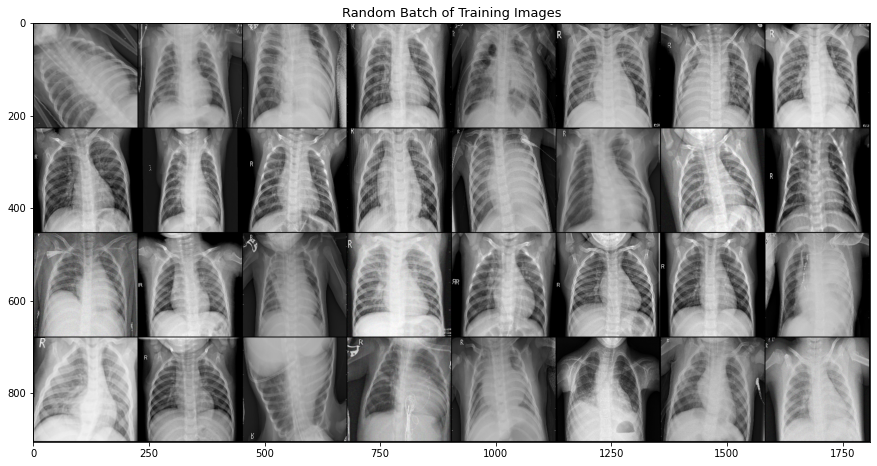

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(15, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Random Batch of Training Images", size=13)
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, groups=64, kernel_size=(3, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, groups=128, kernel_size=(3, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
          )
    
      self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(7680, 1046),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.3),
            nn.Linear(1046, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.3),
            nn.Linear(256, 2)
          )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.dense_layers(x)
        return x

In [0]:
model = Network().to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
objective = nn.CrossEntropyLoss().to(device)

In [0]:
def visualize_eval(train_loss, val_loss) :
    plt.figure(figsize=(5, 5))
    epochs = range(1, 1 + len(train_loss)) 
    plt.style.use('seaborn-white')
    plt.plot(epochs, train_loss, color='blue', label='Train loss')
    plt.plot(epochs, val_loss, color='orange', label='Valdation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [0]:
def fit(model, train_loader=None, val_loader=None, epochs=15):
    torch.manual_seed(0)
    train_loss = []
    val_loss = []
    for epoch in range(1, epochs+1):
        print('\nEpoch {}/{}'.format(epoch, epochs))
        training_loss = []
        validation_loss = []
    
        for batch_x, batch_y in tqdm(train_loader):
            train_x, train_y = batch_x.to(device), batch_y.to(device)
            outputs = model(train_x) # forward propagation
            loss = objective(outputs, train_y) # compute the loss
            training_loss.append(loss.item())
            loss.backward() # backpropagation 
            optimizer.step() # optimization step
            optimizer.zero_grad() # set parameter gradients to zero
    
        with torch.set_grad_enabled(False):
            for val_batch_x, val_batch_y in val_loader:
                val_x, val_y = val_batch_x.to(device), val_batch_y.to(device)
                val_outputs = model(val_x)
                loss_val = objective(val_outputs, val_y)
                validation_loss.append(loss_val.item())

        training_loss = np.average(training_loss)
        validation_loss = np.average(validation_loss)
        train_loss.append(training_loss)
        val_loss.append(validation_loss)
        print('\ttrain_loss: %.4f\t\n' % training_loss, '\tval_loss: %.4f\t' % validation_loss)
    visualize_eval(train_loss, val_loss)


Epoch 1/15



	train_loss: 0.5019	
 	val_loss: 0.7420	

Epoch 2/15



	train_loss: 0.2781	
 	val_loss: 1.0936	

Epoch 3/15



	train_loss: 0.2189	
 	val_loss: 0.6237	

Epoch 4/15



	train_loss: 0.1896	
 	val_loss: 0.9194	

Epoch 5/15



	train_loss: 0.1810	
 	val_loss: 0.7101	

Epoch 6/15



	train_loss: 0.1772	
 	val_loss: 0.5871	

Epoch 7/15



	train_loss: 0.1645	
 	val_loss: 0.7323	

Epoch 8/15



	train_loss: 0.1483	
 	val_loss: 0.7604	

Epoch 9/15



	train_loss: 0.1492	
 	val_loss: 0.8317	

Epoch 10/15



	train_loss: 0.1439	
 	val_loss: 0.7956	

Epoch 11/15



	train_loss: 0.1445	
 	val_loss: 0.6911	

Epoch 12/15



	train_loss: 0.1435	
 	val_loss: 0.2203	

Epoch 13/15



	train_loss: 0.1401	
 	val_loss: 0.3929	

Epoch 14/15



	train_loss: 0.1366	
 	val_loss: 0.7405	

Epoch 15/15



	train_loss: 0.1311	
 	val_loss: 0.5297	


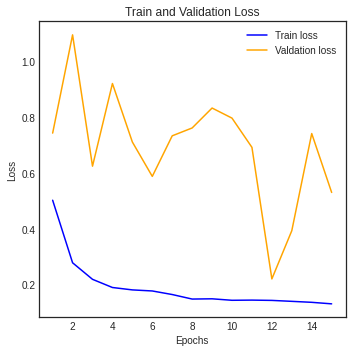

In [13]:
fit(model=model, 
    train_loader=train_loader, 
    val_loader=val_loader)

In [0]:
model.eval()
raw_outputs = list(map(lambda x: model(x), test_loader))
_, predicted = torch.max(raw_outputs[0], 1)
pred_classes = predicted.to('cpu').detach().numpy()

<Figure size 432x288 with 0 Axes>

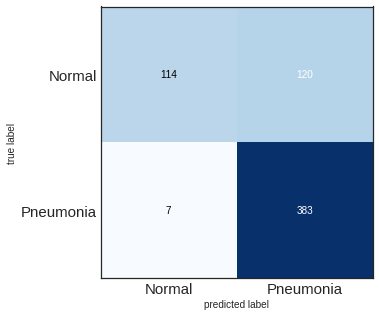

In [15]:
cm  = confusion_matrix(y_test, pred_classes)
plt.figure()
plot_confusion_matrix(cm,figsize=(15, 5), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=15)
plt.show()

In [16]:
f1score = f1_score(y_test, pred_classes)
rec = recall_score(y_test, pred_classes)
pre = precision_score(y_test, pred_classes) 
bal_acc = balanced_accuracy_score(y_test, pred_classes)
roc_auc = roc_auc_score(y_test, pred_classes)
scores = [f1score, roc_auc, rec, pre, bal_acc]

scoring_df = pd.DataFrame({'Metric' : ["F1-Score", "ROC AUC", "Recall", "Precision", "Balanced Acc"],
                           "Score": scores})

pd.options.display.float_format = '{:,.2f}'.format
scoring_df

,Metric,Score
0,F1-Score,0.86
1,ROC AUC,0.73
2,Recall,0.98
3,Precision,0.76
4,Balanced Acc,0.73
